# Data Processing

## import packages

In [1]:
import numpy as np
import pandas as pd
from arbitragerepair import constraints, repair

In [2]:
raw_data = pd.read_csv('fqjo3s8eacwzxkcw.csv')

In [3]:
# Choose Amazon as the underlying stock
df = raw_data.loc[raw_data.ticker=='AMZN', 
                  ['date','exdate','cp_flag','strike_price','best_bid','best_offer','volume','impl_volatility']].copy()
df['date'] = pd.to_datetime(df['date'])
df['exdate'] = pd.to_datetime(df['exdate'])
df['strike_price'] = df['strike_price']/1000 # scaling strike
df['option_price'] = df[['best_bid','best_offer']].mean(axis=1)
df = df.drop(columns = ['best_bid','best_offer'])
df.head()

,date,exdate,cp_flag,strike_price,volume,impl_volatility,option_price
0,2018-01-02,2018-01-05,C,1000.0,0,0.962943,189.975
1,2018-01-02,2018-01-05,C,1002.5,0,0.951017,187.475
2,2018-01-02,2018-01-05,C,1005.0,0,0.939104,184.975
3,2018-01-02,2018-01-05,C,1007.5,0,0.927205,182.475
4,2018-01-02,2018-01-05,C,1010.0,0,0.915319,179.975


In [4]:
# Assume t0 = 2018-01-02
df.loc[df.date=='2018-01-02','exdate'].unique()

<DatetimeArray>
['2018-01-05 00:00:00', '2018-01-12 00:00:00', '2018-01-19 00:00:00',
 '2018-01-26 00:00:00', '2018-02-02 00:00:00', '2018-02-09 00:00:00',
 '2018-02-16 00:00:00', '2018-03-16 00:00:00', '2018-04-20 00:00:00',
 '2018-06-15 00:00:00', '2018-07-20 00:00:00', '2018-09-21 00:00:00',
 '2019-01-18 00:00:00', '2019-06-21 00:00:00', '2020-01-17 00:00:00']
Length: 15, dtype: datetime64[ns]

## Fixed $T_1$, $T_2$, and drag back different $t_0$

In [5]:
# Choose t1 = '2018-01-19', t2 = '2018-04-20' (arbitrarily,temporarily)

t1 = '2018-01-19'
t2 = '2018-04-20'

# call options data
df_t1_C = df.loc[(df.exdate==t1)&(df.cp_flag=='C'), ['date','exdate','strike_price','volume','option_price','impl_volatility']]
df_t2_C = df.loc[(df.exdate==t2)&(df.cp_flag=='C'), ['date','exdate','strike_price','volume','option_price','impl_volatility']]

# put options data
df_t1_P = df.loc[(df.exdate==t1)&(df.cp_flag=='P'), ['date','exdate','strike_price','volume','option_price','impl_volatility']]
df_t2_P = df.loc[(df.exdate==t2)&(df.cp_flag=='P'), ['date','exdate','strike_price','volume','option_price','impl_volatility']]

In [6]:
df_t1_C

,date,exdate,strike_price,volume,option_price,impl_volatility
674,2018-01-02,2018-01-19,1000.0,553,191.525,0.462778
675,2018-01-02,2018-01-19,1005.0,11,186.275,0.439147
676,2018-01-02,2018-01-19,1010.0,2,181.275,0.428202
677,2018-01-02,2018-01-19,1015.0,1,175.875,0.395402
678,2018-01-02,2018-01-19,1020.0,6,170.975,0.390632
...,...,...,...,...,...,...
47139,2018-01-19,2018-01-19,975.0,43,317.725,NaN
47140,2018-01-19,2018-01-19,980.0,66,312.725,NaN
47141,2018-01-19,2018-01-19,985.0,60,308.375,NaN
47142,2018-01-19,2018-01-19,990.0,232,302.725,NaN


In [7]:
# t0 to proceed with
t0List = list(df_t1_C.date.unique())

print(len(t0List))
print(t0List) 

13
[Timestamp('2018-01-02 00:00:00'), Timestamp('2018-01-03 00:00:00'), Timestamp('2018-01-04 00:00:00'), Timestamp('2018-01-05 00:00:00'), Timestamp('2018-01-08 00:00:00'), Timestamp('2018-01-09 00:00:00'), Timestamp('2018-01-10 00:00:00'), Timestamp('2018-01-11 00:00:00'), Timestamp('2018-01-12 00:00:00'), Timestamp('2018-01-16 00:00:00'), Timestamp('2018-01-17 00:00:00'), Timestamp('2018-01-18 00:00:00'), Timestamp('2018-01-19 00:00:00')]


## Revise stock prices

### Upload stock data


In [8]:
import datetime as dt
import yfinance as yf
amzn = yf.Ticker("AMZN")
#amzn.info
#amzn.institutional_holders

start_date = dt.datetime(2018, 1, 1)

tickers_list = ['AMZN']

df_amzn = yf.download(tickers_list, start=start_date, progress=True)
print(df_amzn.head())
fn = './amzn_stock_daily.csv'
df_amzn.to_csv(fn, sep=',', encoding='utf-8')
print('saved to %s'%(fn))

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-01-02  58.599998  59.500000  58.525501  59.450500  59.450500  53890000
2018-01-03  59.415001  60.274502  59.415001  60.209999  60.209999  62176000
2018-01-04  60.250000  60.793499  60.233002  60.479500  60.479500  60442000
2018-01-05  60.875500  61.457001  60.500000  61.457001  61.457001  70894000
2018-01-08  61.799999  62.653999  61.601501  62.343498  62.343498  85590000
saved to ./amzn_stock_daily.csv


In [9]:
df_amzn.reset_index(inplace=True)
df_amzn['date'] = pd.to_datetime(df_amzn['Date'], format="%d/%m/%y")
stock_AMZN = df_amzn[['date','Adj Close']].copy()
stock_AMZN.rename(columns = {'Adj Close' : 'stock_price'}, inplace = True)
stock_AMZN

,date,stock_price
0,2018-01-02,59.450500
1,2018-01-03,60.209999
2,2018-01-04,60.479500
3,2018-01-05,61.457001
4,2018-01-08,62.343498
...,...,...
1560,2024-03-15,174.419998
1561,2024-03-18,174.479996
1562,2024-03-19,175.899994
1563,2024-03-20,178.149994


### Revise


In [10]:
split_data = {
    'date': ['2022-06-06', '1999-09-02', '1999-01-05', '1998-06-02'],
    'split': ['20:1', '2:1', '3:1', '2:1'],
    'multiple': [20, 2, 3, 2]
}
df_splits = pd.DataFrame(split_data)
df_splits['date'] = pd.to_datetime(df_splits['date'])
df_splits = df_splits.sort_values(by='date', ascending=False)

# Define a function to adjust stock prices based on splits.
def adjust_prices_for_splits(stock_prices_df, splits_df):
    adjusted_prices = stock_prices_df.copy()
    adjusted_prices['adjusted_price'] = adjusted_prices['stock_price']
    
    # Apply splits in reverse chronological order
    for _, split in splits_df.iterrows():
        split_date = split['date']
        split_multiple = split['multiple']
        mask = adjusted_prices['date'] < split_date
        adjusted_prices.loc[mask, 'adjusted_price'] *= split_multiple
        
    return adjusted_prices

# Adjust the AMZN stock prices for splits
stock_AMZN = adjust_prices_for_splits(stock_AMZN, df_splits)
stock_AMZN

,date,stock_price,adjusted_price
0,2018-01-02,59.450500,1189.010010
1,2018-01-03,60.209999,1204.199982
2,2018-01-04,60.479500,1209.589996
3,2018-01-05,61.457001,1229.140015
4,2018-01-08,62.343498,1246.869965
...,...,...,...
1560,2024-03-15,174.419998,174.419998
1561,2024-03-18,174.479996,174.479996
1562,2024-03-19,175.899994,175.899994
1563,2024-03-20,178.149994,178.149994


## Check Data Arbitrage
We use put call parity: $C-P=S_0-Ke^{-rT}$ to compute r: $r=-\frac{1}{T}\cdot\ln(\frac{S_{0}-C+P}{K})$.

I set up the function to compute the B-S Price to have a check

In [11]:
from scipy.stats import norm
from enum import Enum
import numpy as np

class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'

def computeR(S, C, P, T, K):
    r = -1/T * np.log((S-C+P)/K)
    return r
    
def bsPrice(S, r, vol, T, K, payoffType):
    fwd = S * np.exp(r * T)
    stdev = vol * np.sqrt(T)
    d1 = np.log(fwd / K) / stdev + stdev / 2
    d2 = d1 - stdev
    
    if payoffType == PayoffType.Call:
        return np.exp(-r * T) * (fwd * norm.cdf(d1) - K * norm.cdf(d2))
    elif payoffType == PayoffType.Put:
        return np.exp(-r * T) * (K * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    else:
        raise Exception("not supported payoff type", payoffType) 
        

**Test Data**

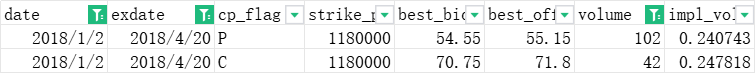

In [12]:
#Test
S, C, P, T, K = 1189.01, 71.275, 54.85, 79/252, 1180
r = computeR(S, C, P, T, K)
vol_C = 0.247818
vol_P = 0.240743

print("blackPrice_C: ", bsPrice(S, r, vol_C, T, K, PayoffType.Call))
print("marketPrice_C: ", C)
print("blackPrice_P: ", bsPrice(S, r, vol_P, T, K, PayoffType.Put))
print("marketPrice_P: ", P)

blackPrice_C:  73.85043953317997
marketPrice_C:  71.275
blackPrice_P:  55.57339021660465
marketPrice_P:  54.85


It seems great! :)

## Arbitrage Repair

In [13]:
# Arbitrage repair function
def arbitrageRepair(columnT, columnK, columnC, columnF):
    # normalise strikes and call prices
    normaliser = constraints.Normalise()
    T = np.array(columnT)
    K = np.array(columnK)
    C = np.array(columnC)
    F = np.array(columnF)
    normaliser.fit(T, K, C, F)
    T1, K1, C1 = normaliser.transform(T, K, C)
    
    # construct arbitrage constraints and detect violation
    mat_A, vec_b, _, _ = constraints.detect(T1, K1, C1, verbose=False)
    
    # repair arbitrage - l1-norm objective
    epsilon = repair.l1(mat_A, vec_b, C1)
    
    # de-normalise
    K0, C0 = normaliser.inverse_transform(K1, C1 + epsilon)
    
    return K0, C0

In [14]:
# pip install pandas_market_calendars
import pandas_market_calendars as mcal

In [15]:
result = pd.DataFrame()

for t0 in t0List:
    ## T1:
    # t1: 20 largest trading volume
    df_t0t1 = df_t1_C[df_t1_C.date==t0].sort_values('volume',ascending=False).iloc[0:20].drop(columns='volume').reset_index(drop=True)
    
    # merge with put options data and stock price data
    df_t0t1 = df_t0t1.merge(df_t1_P, on = ['date','exdate','strike_price'], suffixes = ('_C','_P'))
    df_t0t1 = pd.merge(df_t0t1, stock_AMZN, on = 'date')
    
    # calculate the forward price:
    df_t0t1['forward_price'] = df_t0t1['adjusted_price']/((df_t0t1['adjusted_price']-(df_t0t1['option_price_C']-df_t0t1['option_price_P']))/df_t0t1['strike_price'])
    #df_t0t1['forward_price'] = df_t0t1['adjusted_price']
    
    # calculate the expiry:
    # Amazon (AMZN) is listed on the NASDAQ exchange
    amzn_t = mcal.get_calendar('NASDAQ')
    trading_days_1 = amzn_t.valid_days(start_date=t0, end_date=t1)
    df_t0t1['expiry'] = len(trading_days_1) / 252
    #df_t0t1['expiry'] = (df_t0t1['exdate']-df_t0t1['date']).apply(lambda x: x.days/365)
    
    # arbitrage repair:
    K0_t1, C0_t1 = arbitrageRepair(df_t0t1['expiry'], df_t0t1['strike_price'], df_t0t1['option_price_C'], df_t0t1['forward_price'])
       
    # temporary result at t0:
    result_t1 = df_t0t1[['date','exdate']].copy()
    result_t1['strike_price'] = K0_t1
    result_t1['call_option_price'] = C0_t1
        
    
    ## T2:
    # t2: 20 largest trading volume
    df_t0t2 = df_t2_C[df_t2_C.date==t0].sort_values('volume',ascending=False).iloc[0:20].drop(columns='volume').reset_index(drop=True)
    
    # merge with put options data and stock price data
    df_t0t2 = pd.merge(df_t0t2, df_t2_P, on = ['date','exdate','strike_price'], suffixes = ('_C','_P'))
    df_t0t2 = pd.merge(df_t0t2, stock_AMZN, on = 'date')
    
    # calculate the forward price:
    df_t0t2['forward_price'] = df_t0t2['adjusted_price']/((df_t0t2['adjusted_price']-(df_t0t2['option_price_C']-df_t0t2['option_price_P']))/df_t0t2['strike_price'])
    # df_t0t2['forward_price'] = df_t0t2['adjusted_price']
    
    # calculate the expiry:
    trading_days_2 = amzn_t.valid_days(start_date=t0, end_date=t2)
    df_t0t2['expiry'] = len(trading_days_2) / 252
    # df_t0t2['expiry'] = (df_t0t2['exdate']-df_t0t2['date']).apply(lambda x: x.days/365)
    
    # arbitrage repair:
    K0_t2, C0_t2 = arbitrageRepair(df_t0t2['expiry'], df_t0t2['strike_price'], df_t0t2['option_price_C'], df_t0t2['forward_price'])
    
    # temporary result at t0:
    result_t2 = df_t0t2[['date','exdate']].copy()
    result_t2['strike_price'] = K0_t2
    result_t2['call_option_price'] = C0_t2
    
    
    ## Concat horizontally  
    result_tmp = pd.concat([result_t1, result_t2.drop(columns='date')], axis=1)
    
    ## Concat vertically
    result = pd.concat([result,result_tmp], axis=0)
    
result.columns = ['date', 'T1', 'K1', 'C1',  'T2', 'K2', 'C2']
result = result.reset_index(drop=True)
result = pd.merge(result, stock_AMZN, on = 'date')
result.columns = ['t0', 'T1', 'K1', 'C1',  'T2', 'K2', 'C2',  'S0', 'Adj_S0']

C:\Users\qyh18\Empirical-Price-Bounds\arbitragerepair\constraints.py:515: RuntimeWarning: invalid value encountered in cast
  raw_index = df['raw_index'].values.astype(int)
C:\Users\qyh18\Empirical-Price-Bounds\arbitragerepair\constraints.py:561: RuntimeWarning: invalid value encountered in cast
  raw_index = df['raw_index'].values.astype(int)
C:\Users\qyh18\Empirical-Price-Bounds\arbitragerepair\constraints.py:621: RuntimeWarning: invalid value encountered in cast
  raw_index = df['raw_index'].values.astype(int)
C:\Users\qyh18\Empirical-Price-Bounds\arbitragerepair\constraints.py:515: RuntimeWarning: invalid value encountered in cast
  raw_index = df['raw_index'].values.astype(int)
C:\Users\qyh18\Empirical-Price-Bounds\arbitragerepair\constraints.py:561: RuntimeWarning: invalid value encountered in cast
  raw_index = df['raw_index'].values.astype(int)
C:\Users\qyh18\Empirical-Price-Bounds\arbitragerepair\constraints.py:621: RuntimeWarning: invalid value encountered in cast
  raw_index

C:\Users\yanhui\Desktop\ipython\optionPricing\git-Empirical-Option-Pricing\Empirical-Option-Pricing\arbitragerepair\constraints.py:515: RuntimeWarning: invalid value encountered in cast
  raw_index = df['raw_index'].values.astype(int)
C:\Users\yanhui\Desktop\ipython\optionPricing\git-Empirical-Option-Pricing\Empirical-Option-Pricing\arbitragerepair\constraints.py:561: RuntimeWarning: invalid value encountered in cast
  raw_index = df['raw_index'].values.astype(int)
C:\Users\yanhui\Desktop\ipython\optionPricing\git-Empirical-Option-Pricing\Empirical-Option-Pricing\arbitragerepair\constraints.py:621: RuntimeWarning: invalid value encountered in cast
  raw_index = df['raw_index'].values.astype(int)
C:\Users\yanhui\Desktop\ipython\optionPricing\git-Empirical-Option-Pricing\Empirical-Option-Pricing\arbitragerepair\constraints.py:515: RuntimeWarning: invalid value encountered in cast
  raw_index = df['raw_index'].values.astype(int)
C:\Users\yanhui\Desktop\ipython\optionPricing\git-Empirical-

In [16]:
print(result.shape)
result

(260, 9)


,t0,T1,K1,C1,T2,K2,C2,S0,Adj_S0
0,2018-01-02,2018-01-19,1000.0,191.525000,2018-04-20,800.0,396.725000,59.450500,1189.010010
1,2018-01-02,2018-01-19,1100.0,92.525000,2018-04-20,1015.0,191.675000,59.450500,1189.010010
2,2018-01-02,2018-01-19,1150.0,46.075000,2018-04-20,1025.0,183.025000,59.450500,1189.010010
3,2018-01-02,2018-01-19,1160.0,38.000000,2018-04-20,1050.0,157.776341,59.450500,1189.010010
4,2018-01-02,2018-01-19,1170.0,30.450000,2018-04-20,1080.0,137.850000,59.450500,1189.010010
...,...,...,...,...,...,...,...,...,...
255,2018-01-19,2018-01-19,1320.0,0.004999,2018-04-20,1540.0,9.155561,64.728996,1294.579926
256,2018-01-19,2018-01-19,1322.5,0.005000,2018-04-20,1560.0,7.900000,64.728996,1294.579926
257,2018-01-19,2018-01-19,1325.0,0.005000,2018-04-20,1680.0,3.020000,64.728996,1294.579926
258,2018-01-19,2018-01-19,1330.0,0.004999,2018-04-20,1720.0,2.305000,64.728996,1294.579926


In [17]:
# result.to_csv('data_20180119_20180420.csv', header=True)

In [18]:
# K = [[np.array(result.loc[result.t0 == t0,'K1']),np.array(result.loc[result.t0==t0,'K2'])] for t0 in t0List]
# Pi = [[np.array(result.loc[result.t0 == t0,'C1']),np.array(result.loc[result.t0==t0,'C2'])] for t0 in t0List]